*Joe Harman  
2019-03-19 18:07:42  
Redone 26/04/2019*

# Drug screen overlap with MLLAF4 GRN

Here I'm taking the drug-gene interaction database from DGIdb and establishing the overlaps with the MLLAF4 network to determine potential druggable applications towards MLLAF4 downstream targets

## Setup

In [2]:
library(tidyverse)
library(ggplot2)
library(igraph)
library(ggrepel)

In [3]:
drug_int <- read_tsv("interactions.tsv") %>%
    select(symbol = gene_name, entrez = entrez_id, interaction_types, drug_name) %>%
    mutate(interaction_types = replace(interaction_types, is.na(interaction_types), "unknown")) %>%
    filter(!is.na(symbol) & !is.na(drug_name))

nodes <- read_graph("../Aggregated_networks/MLL-AF4/AggregatedGraph_MLL-AF4.gml", "gml") %>%
    igraph::as_data_frame(what="vertices") %>%
    select(entrez=name, symbol, degree, stress, Percexpressed, MLLAF4logFC, Dropoutclass)

Parsed with column specification:
cols(
  gene_name = col_character(),
  gene_claim_name = col_character(),
  entrez_id = col_double(),
  interaction_claim_source = col_character(),
  interaction_types = col_character(),
  drug_claim_name = col_character(),
  drug_claim_primary_name = col_character(),
  drug_name = col_character(),
  drug_chembl_id = col_character(),
  PMIDs = col_number()
)


In [4]:
drugs <- unique(drug_int$drug_name)

In [5]:
head(drugs)

head(drug_int)

head(nodes)

[1] "BMS-387032"   "CHEMBL72862"  "PREDNISONE"   "ISOFLAVONE"   "QUIZARTINIB" 
[6] "CHEMBL561708"

symbol,entrez,interaction_types,drug_name
<chr>,<dbl>,<chr>,<chr>
CDK7,1022,inhibitor,BMS-387032
ADORA2A,135,antagonist,CHEMBL72862
APOE,348,unknown,PREDNISONE
CYP2E1,1571,unknown,ISOFLAVONE
PDGFRB,5159,inhibitor,QUIZARTINIB
MTOR,2475,inhibitor,CHEMBL561708


,entrez,symbol,degree,stress,Percexpressed,MLLAF4logFC,Dropoutclass
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1958,1958,EGR1,464,29049,100.0000,0.9345442,non-dropout
2355,2355,FOSL2,217,7404,98.4127,-0.5205269,non-dropout
405,405,ARNT,559,7646,100.0000,0.2374961,non-leukemia-specific dropout
4609,4609,MYC,1154,89851,100.0000,-0.2487874,non-leukemia-specific dropout
6239,6239,RREB1,319,15594,100.0000,0.2578800,non-dropout
6772,6772,STAT1,404,21662,100.0000,0.2396495,non-dropout


## Drug hits in network
Here we're first establishing the genes targeted by each drug, then determining the frequency of hits in the GRN and the frequency of offtarget hits.

In [6]:
genes_per_drug <- sapply(drugs, function(d){
    g <- drug_int$symbol[drug_int$drug_name == d] %>%
        unique()
})

In [7]:
drug_net_df <- lapply(genes_per_drug, function(g){
    c(
        freq_in_network = sum(nodes$symbol %in% g),
        freq_offtarget = sum(!(g %in% nodes$symbol))
    )
}) %>%
    bind_rows() %>%
    t() %>%
    data.frame() %>%
    rename(freq_in_network = X1, freq_offtarget = X2) %>%
    rownames_to_column("drug_name") %>%
    mutate(perc_on_target = freq_in_network/(freq_in_network + freq_offtarget) * 100) %>%
    arrange(desc(freq_in_network))

In [8]:
head(drug_net_df)

drug_name,freq_in_network,freq_offtarget,perc_on_target
<chr>,<int>,<int>,<dbl>
BORTEZOMIB,39,35,52.70270
CARFILZOMIB,31,23,57.40741
PACLITAXEL,29,40,42.02899
OPROZOMIB,29,9,76.31579
IXAZOMIB CITRATE,29,9,76.31579
TRETINOIN,28,50,35.89744


## Plotting on target hits against offtarget

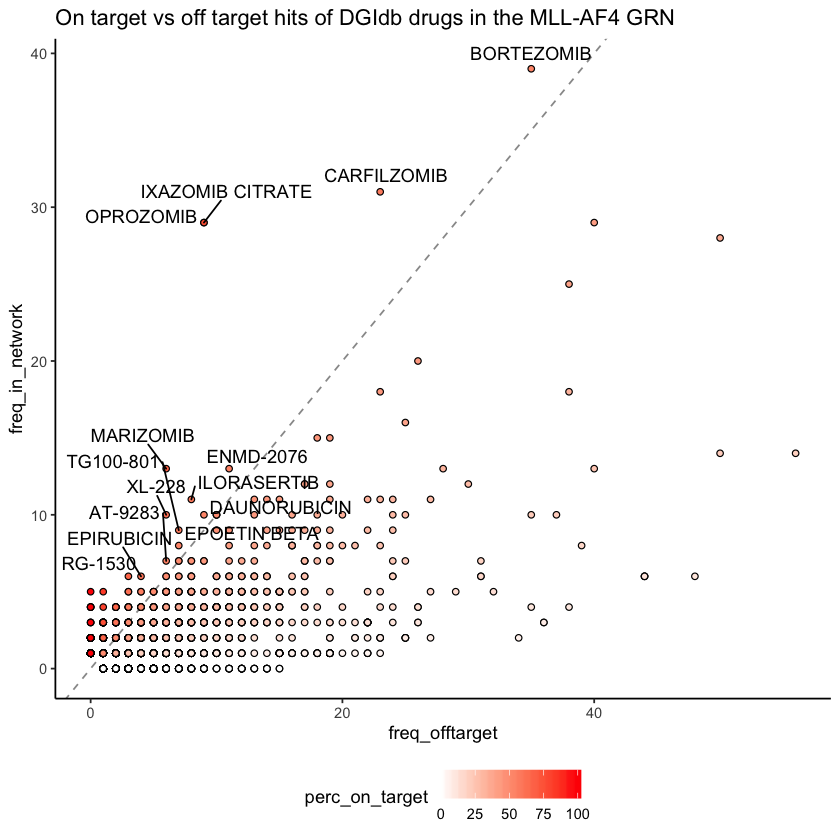

In [9]:
p <- ggplot(drug_net_df, aes(x=freq_offtarget, y=freq_in_network, fill=perc_on_target)) +
    geom_abline(intercept = 0, slope = 1, lty=2, col="grey60") +
    geom_point(pch=21) +
    geom_text_repel(aes(label = drug_name), data=filter(drug_net_df, perc_on_target > 50 & freq_in_network > 5), nudge_y = 1) +
    scale_fill_gradient(low = "white", high = "red") +
    theme_classic() +
    theme(legend.position="bottom") +
    ggtitle("On target vs off target hits of DGIdb drugs in the MLL-AF4 GRN")

p

In [10]:
ggsave("on-target_vs_off-target_hits_DGIdb_screen.pdf", p, height=6, width=6, useDingbats = F)

## What are the most "specific" drugs?
Below is the list of drugs, and their targets, that hit more than 5 nodes of the GRN and have > 50% on target hit rate.

We can see here that the most promising drugs are OPROZOMIB, IXAZOMIB CITRATE and MARIZOMIB. Other drugs either do not effect many nodes of the network, or have fairly poor on target percentage (CARFILZOMIB, BORTEZOMIB)

* OPROZOMIB is a proteasome inhibitor that is structurally related to CARFILZOMIB, and is being investigated for treatment of multiple myeloma
* IZAXOMIB CITRATE is a proteasome inhibitor that is also being investigated for treatment of multiple myeloma

Worth pointing out, according to DGIdb OPROZOMIB and IXAZOMIB CITRATE interact with the same set of genes, and may have simply had the entire proteasome set as interactions rather than specific aspects...

In [16]:
drugs.df <- drug_net_df %>%
    mutate(specific = perc_on_target > 50 & freq_in_network > 5) %>%
    arrange(desc(specific))

drugs.df %>% head

drug_name,freq_in_network,freq_offtarget,perc_on_target,specific
<chr>,<int>,<int>,<dbl>,<lgl>
BORTEZOMIB,39,35,52.70270,TRUE
CARFILZOMIB,31,23,57.40741,TRUE
OPROZOMIB,29,9,76.31579,TRUE
IXAZOMIB CITRATE,29,9,76.31579,TRUE
ENMD-2076,13,11,54.16667,TRUE
MARIZOMIB,13,6,68.42105,TRUE


In [17]:
write_csv(drugs.df, "GRN_DGIdb_overlap.csv")

In [13]:
print("OPROZOMIB:")
genes_per_drug$OPROZOMIB %>% sort()

print("IXAZOMIB CITRATE:")
genes_per_drug$`IXAZOMIB CITRATE` %>% sort()

[1] "OPROZOMIB:"


[1] "ADRM1"  "PSMA1"  "PSMA2"  "PSMA3"  "PSMA4"  "PSMA5"  "PSMA6"  "PSMA7" 
 [9] "PSMA8"  "PSMB1"  "PSMB10" "PSMB11" "PSMB2"  "PSMB3"  "PSMB4"  "PSMB5" 
[17] "PSMB6"  "PSMB7"  "PSMB8"  "PSMB9"  "PSMC1"  "PSMC2"  "PSMC3"  "PSMC4" 
[25] "PSMC5"  "PSMC6"  "PSMD1"  "PSMD11" "PSMD12" "PSMD13" "PSMD14" "PSMD2" 
[33] "PSMD3"  "PSMD4"  "PSMD6"  "PSMD7"  "PSMD8"  "SEM1"

[1] "IXAZOMIB CITRATE:"


[1] "ADRM1"  "PSMA1"  "PSMA2"  "PSMA3"  "PSMA4"  "PSMA5"  "PSMA6"  "PSMA7" 
 [9] "PSMA8"  "PSMB1"  "PSMB10" "PSMB11" "PSMB2"  "PSMB3"  "PSMB4"  "PSMB5" 
[17] "PSMB6"  "PSMB7"  "PSMB8"  "PSMB9"  "PSMC1"  "PSMC2"  "PSMC3"  "PSMC4" 
[25] "PSMC5"  "PSMC6"  "PSMD1"  "PSMD11" "PSMD12" "PSMD13" "PSMD14" "PSMD2" 
[33] "PSMD3"  "PSMD4"  "PSMD6"  "PSMD7"  "PSMD8"  "SEM1"

In [24]:
genes_per_drug$OPROZOMIB %in% genes_per_drug$CARFILZOMIB

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE